In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Bidirectional, TimeDistributed, Flatten, Activation, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint

from tqdm.notebook import tqdm
from statistics import mean
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

# Load & Prepare Data

In [2]:
# Load Data
df = yf.download(tickers='RCDO.L', start='2012-01-01', end='2023-01-01')
df = df[['Close']]
df

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2012-01-03,381.5
2012-01-04,384.0
2012-01-05,383.5
2012-01-06,383.5
2012-01-09,380.0
...,...
2022-12-22,475.0
2022-12-23,475.0
2022-12-28,477.5


In [3]:
# training between 2012 and 2022
train_data_df = df[df.index < '2022-01-01'].copy()

# validation on 2022
val_data_df = df[df.index >= '2022-01-01'].copy()

display(train_data_df, val_data_df)

,Close
Date,
2012-01-03,381.5
2012-01-04,384.0
2012-01-05,383.5
2012-01-06,383.5
2012-01-09,380.0
...,...
2021-12-23,465.0
2021-12-24,464.0
2021-12-29,462.0


,Close
Date,
2022-01-04,457.0
2022-01-05,463.0
2022-01-06,466.0
2022-01-07,467.0
2022-01-10,463.0
...,...
2022-12-22,475.0
2022-12-23,475.0
2022-12-28,477.5


# Models

In [4]:
def plot_loss(history):
    plt.plot(history.history['loss'], label = 'Training Loss')
    plt.plot(history.history['val_loss'], label = 'Validation Loss')
    plt.yticks([i/1000 for i in range(0, 25, 5)])
    plt.legend()
    plt.show()

In [5]:
def visualise_predicitons(test_data_df, pred):
    """Plot predictions against actual test data"""
    
    pred_ = pd.DataFrame(test_data_df['Close'])
    pred_['predicted close'] = pred
    
    plt.figure(figsize=(28,12))
    sns.lineplot(test_data_df['Close'])
    sns.lineplot(pred_['predicted close'])
    plt.show()

In [6]:
def run_model(train_data_df, val_data_df, chosen_model):

    #### Prepare Train Data ####
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_train_data = scaler.fit_transform(train_data_df)

    prediction_days = 7

    x_train = []
    y_train = []

    for i in range(prediction_days, len(scaled_train_data)):
        x_train.append(scaled_train_data[i-prediction_days:i])
        y_train.append(scaled_train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # https://towardsdatascience.com/forecasting-with-technical-indicators-and-gru-lstm-rnn-multivariate-time-series-a3244dcbc38b
    #### Prepare Val Data ####
    look_back = train_data_df.tail(prediction_days)
    val_data = look_back.append(val_data_df)

    scaled_val_data = scaler.transform(val_data)

    x_val = []
    y_val = []
    
    for i in range(prediction_days, len(scaled_val_data)):
        x_val.append(scaled_val_data[i-prediction_days:i])
        y_val.append(scaled_val_data[i, 0])

    x_val, y_val = np.array(x_val), np.array(y_val)
    
    ##### Run model #####
    model = chosen_model
    model.summary()
    model.compile(optimizer='adam', 
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    history = model.fit(x_train, y_train, validation_split=0.1, epochs=100)
    
    ##### Plot loss #####
    plot_loss(history)

    ##### Generate predictions (probabilities - the output of the last layer) on new data using `predict` #####
    print("Generate predictions for 7 samples")
    predictions = model.predict(x_val[:7])
    print("predictions shape:", predictions.shape)
    print(predictions)
    
    ##### Metrics #####
    pred = model.predict(x_val)
    print(pred.shape)

    # Inverse MinMax Transformation
    # Requires same amount of fields
    # https://stackoverflow.com/questions/42997228/lstm-keras-error-valueerror-non-broadcastable-output-operand-with-shape-67704
    # create empty table with 12 fields
    pred_like = np.zeros(shape=(len(pred), 1) )
    # put the predicted values in the right field
    pred_like[:,0] = pred[:,0]
    # inverse transform and then select the right field
    pred = scaler.inverse_transform(pred_like)[:,0]

    print('mae:', mean_absolute_error(val_data_df['Close'], pred))
    print('mape:', mean_absolute_percentage_error(val_data_df['Close'], pred))
    print('mse:', mean_squared_error(val_data_df['Close'], pred))
    print('rmse:', math.sqrt(mean_squared_error(val_data_df['Close'], pred)))

    ##### Visualise #####
    print(y_val.shape, pred.shape)
    visualise_predicitons(val_data_df, pred)

    display(pd.DataFrame(data={'Train Predictions':pred.flatten(), 'Actuals':val_data_df['Close']}))

In [7]:
def run_model_average(train_data_df, val_data_df, chosen_model):

    #### Prepare Train Data ####
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_train_data = scaler.fit_transform(train_data_df)

    prediction_days = 7

    x_train = []
    y_train = []

    for i in range(prediction_days, len(scaled_train_data)):
        x_train.append(scaled_train_data[i-prediction_days:i])
        y_train.append(scaled_train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # https://towardsdatascience.com/forecasting-with-technical-indicators-and-gru-lstm-rnn-multivariate-time-series-a3244dcbc38b
    #### Prepare Val Data ####
    look_back = train_data_df.tail(prediction_days)
    val_data = look_back.append(val_data_df)

    scaled_val_data = scaler.transform(val_data)

    x_val = []
    y_val = []
    
    for i in range(prediction_days, len(scaled_val_data)):
        x_val.append(scaled_val_data[i-prediction_days:i])
        y_val.append(scaled_val_data[i, 0])

    x_val, y_val = np.array(x_val), np.array(y_val)
    
    mape_values = []
    mae_values = []
    mse_values = []
    rmse_values = []
    
    for i in (range(35)):
        
        ##### Run model #####
        model = chosen_model
        model.summary()
        model.compile(optimizer='adam', 
                      loss='mean_squared_error',
                      metrics=['mean_absolute_error'])

        history = model.fit(x_train, y_train, validation_split=0.1, epochs=100)

        ##### Generate predictions (probabilities - the output of the last layer) on new data using `predict` #####
        print("Generate predictions for 7 samples")
        predictions = model.predict(x_val[:7])
        print("predictions shape:", predictions.shape)
        print(predictions)

        ##### Metrics #####
        pred = model.predict(x_val)
        print(pred.shape)

        # Inverse MinMax Transformation
        # Requires same amount of fields
        # https://stackoverflow.com/questions/42997228/lstm-keras-error-valueerror-non-broadcastable-output-operand-with-shape-67704
        # create empty table with 12 fields
        pred_like = np.zeros(shape=(len(pred), 1) )
        # put the predicted values in the right field
        pred_like[:,0] = pred[:,0]
        # inverse transform and then select the right field
        pred = scaler.inverse_transform(pred_like)[:,0]
    
        mae_values.append(mean_absolute_error(val_data_df['Close'], pred))
        mape_values.append(mean_absolute_percentage_error(val_data_df['Close'], pred))
        mse_values.append(mean_squared_error(val_data_df['Close'], pred))
        rmse_values.append(math.sqrt(mean_squared_error(val_data_df['Close'], pred)))
        
        print(mean(mae_values), mean(mape_values), mean(mse_values), mean(rmse_values))
        
    return mae_values, mape_values, mse_values, rmse_values

In [8]:
compare_df = pd.DataFrame(columns=['Name', 'MAE', 'MAPE', 'MSE', 'RMSE'])

## BiLSTM

In [9]:
def bilstm():
    model = Sequential()
    model.add(Bidirectional(LSTM(70, return_sequences=True), input_shape=(7, 1)))
    model.add(Bidirectional(LSTM(50)))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 7, 140)           40320     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              76400     
 nal)                                                            
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 116,821
Trainable params: 116,821
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================]

Epoch 90/100
71/71 [==============================] - 1s 8ms/step - loss: 3.7070e-04 - mean_absolute_error: 0.0131 - val_loss: 1.4781e-04 - val_mean_absolute_error: 0.0085
Epoch 91/100
71/71 [==============================] - 1s 8ms/step - loss: 4.2552e-04 - mean_absolute_error: 0.0144 - val_loss: 1.3322e-04 - val_mean_absolute_error: 0.0083
Epoch 92/100
71/71 [==============================] - 1s 8ms/step - loss: 3.7999e-04 - mean_absolute_error: 0.0134 - val_loss: 1.3127e-04 - val_mean_absolute_error: 0.0082
Epoch 93/100
71/71 [==============================] - 1s 8ms/step - loss: 4.0715e-04 - mean_absolute_error: 0.0139 - val_loss: 1.4240e-04 - val_mean_absolute_error: 0.0083
Epoch 94/100
71/71 [==============================] - 1s 8ms/step - loss: 3.8825e-04 - mean_absolute_error: 0.0136 - val_loss: 1.4963e-04 - val_mean_absolute_error: 0.0086
Epoch 95/100
71/71 [==============================] - 1s 8ms/step - loss: 3.9429e-04 - mean_absolute_error: 0.0139 - val_loss: 1.2831e-04 - 

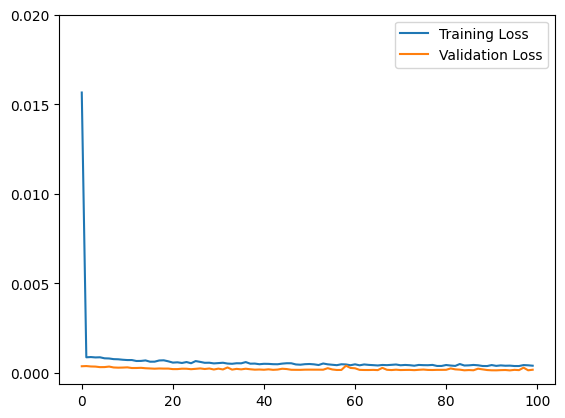

Generate predictions for 7 samples
1/1 [==============================] - 1s 1s/step
predictions shape: (7, 1)
[[0.18254237]
 [0.18964735]
 [0.19799452]
 [0.20252742]
 [0.20395844]
 [0.19987513]
 [0.19582511]]
8/8 [==============================] - 0s 2ms/step
(250, 1)
mae: 6.7757372174039485
mape: 0.01606538302763072
mse: 79.91453526477612
rmse: 8.939493009381243
(250,) (250,)


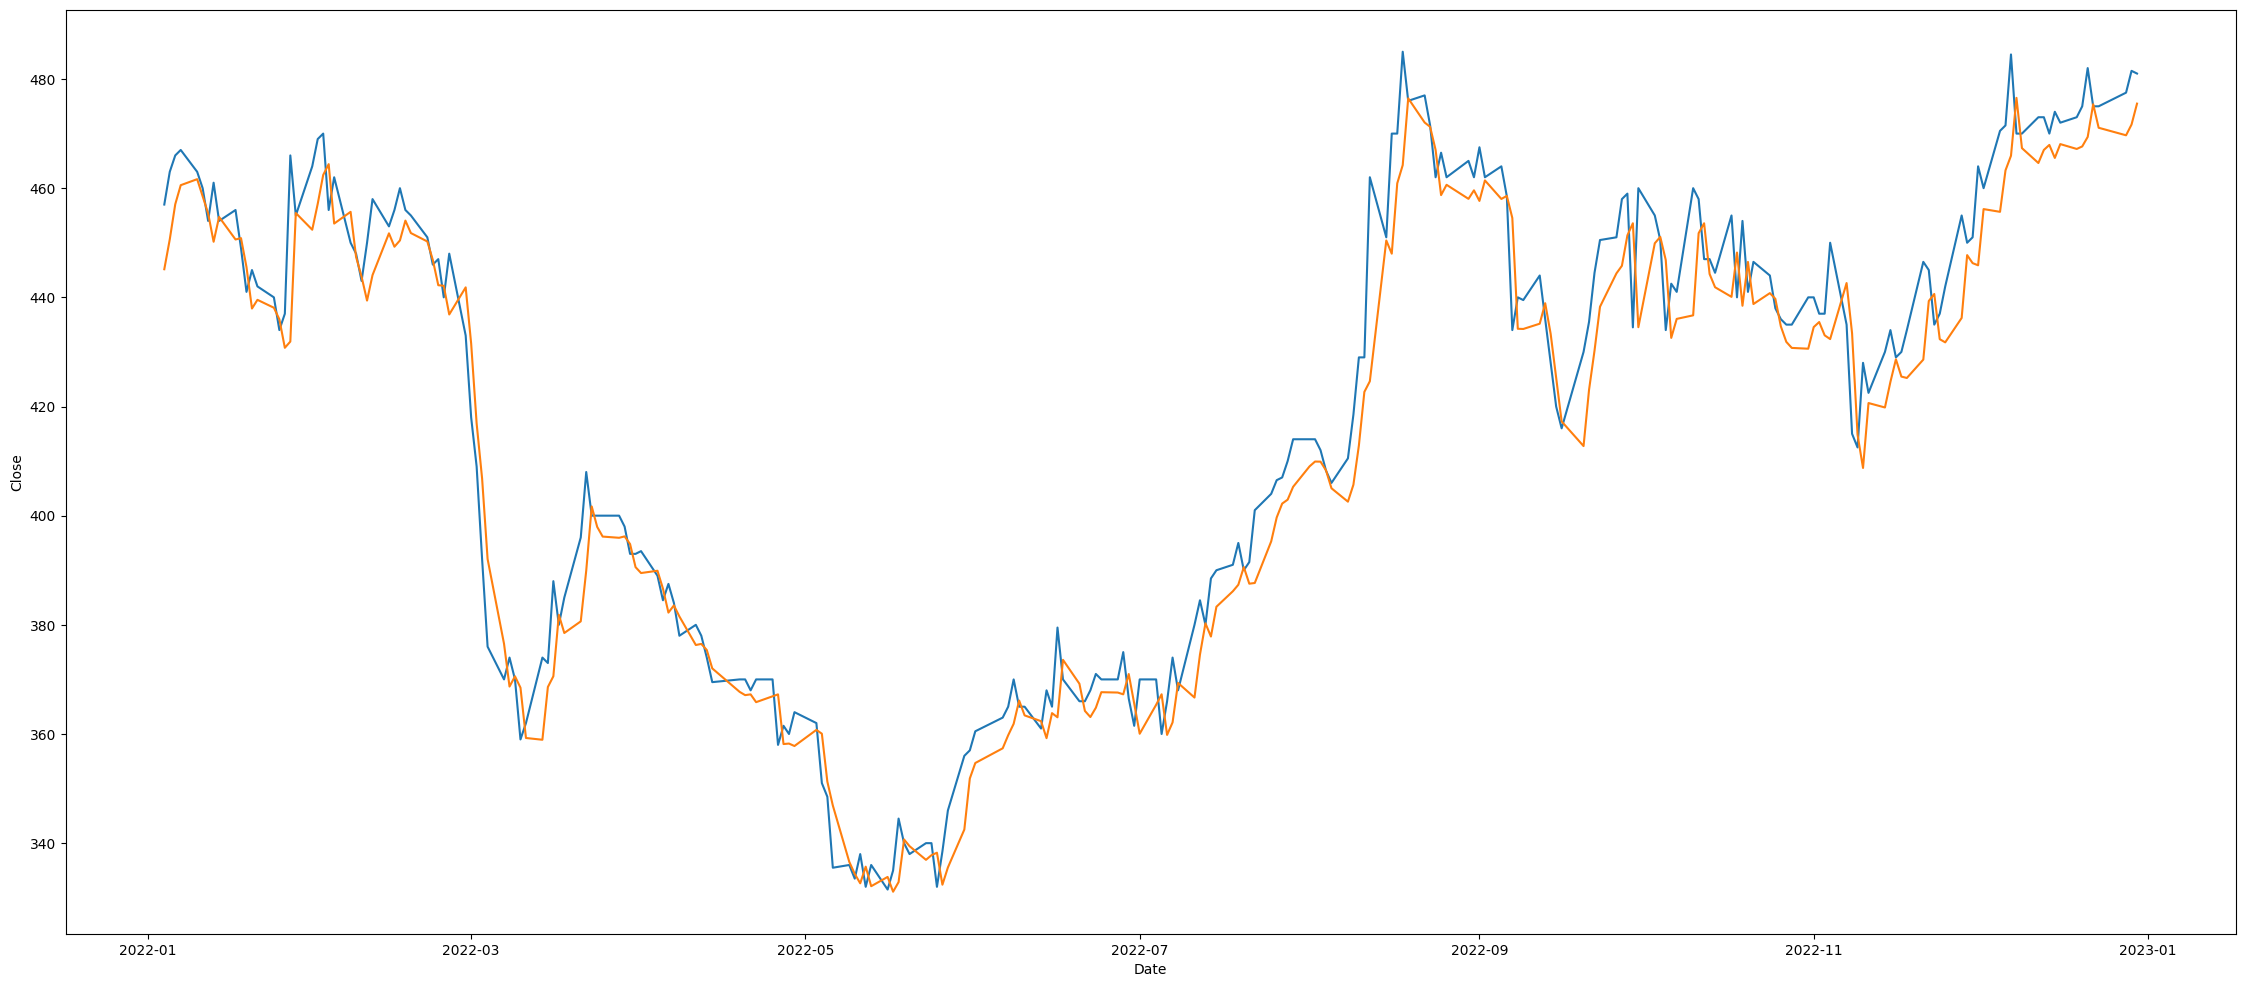

,Train Predictions,Actuals
Date,,
2022-01-04,445.148895,457.0
2022-01-05,450.623281,463.0
2022-01-06,457.054774,466.0
2022-01-07,460.547376,467.0
2022-01-10,461.649976,463.0
...,...,...
2022-12-22,475.384109,475.0
2022-12-23,471.067801,475.0
2022-12-28,469.689225,477.5


In [10]:
run_model(train_data_df, val_data_df, chosen_model = bilstm())

In [11]:
mae_values, mape_values, mse_values, rmse_values = run_model_average(train_data_df, val_data_df, chosen_model = bilstm())
 
model_dict = {
'Name':'Vanilla LSTM 2',
'MAE': round(mean(mae_values), 4),
"MAPE": round(mean(mape_values), 4),
"MSE": round(mean(mse_values), 4),
"RMSE": round(mean(rmse_values), 4)
}

compare_df = compare_df.append(model_dict, ignore_index=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 7, 140)           40320     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 100)              76400     
 nal)                                                            
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 116,821
Trainable params: 116,821
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [=============================

71/71 [==============================] - 1s 10ms/step - loss: 4.4044e-04 - mean_absolute_error: 0.0149 - val_loss: 1.8284e-04 - val_mean_absolute_error: 0.0099
Epoch 90/100
71/71 [==============================] - 1s 10ms/step - loss: 4.0412e-04 - mean_absolute_error: 0.0141 - val_loss: 1.9623e-04 - val_mean_absolute_error: 0.0105
Epoch 91/100
71/71 [==============================] - 1s 10ms/step - loss: 3.8291e-04 - mean_absolute_error: 0.0134 - val_loss: 1.5422e-04 - val_mean_absolute_error: 0.0087
Epoch 92/100
71/71 [==============================] - 1s 10ms/step - loss: 3.9014e-04 - mean_absolute_error: 0.0136 - val_loss: 1.6521e-04 - val_mean_absolute_error: 0.0099
Epoch 93/100
71/71 [==============================] - 1s 10ms/step - loss: 3.8324e-04 - mean_absolute_error: 0.0135 - val_loss: 1.3379e-04 - val_mean_absolute_error: 0.0081
Epoch 94/100
71/71 [==============================] - 1s 10ms/step - loss: 3.9722e-04 - mean_absolute_error: 0.0141 - val_loss: 1.3322e-04 - val_mea

Epoch 76/100
71/71 [==============================] - 1s 8ms/step - loss: 3.8491e-04 - mean_absolute_error: 0.0136 - val_loss: 1.3426e-04 - val_mean_absolute_error: 0.0084
Epoch 77/100
71/71 [==============================] - 1s 8ms/step - loss: 3.5472e-04 - mean_absolute_error: 0.0130 - val_loss: 1.3931e-04 - val_mean_absolute_error: 0.0084
Epoch 78/100
71/71 [==============================] - 1s 8ms/step - loss: 3.9669e-04 - mean_absolute_error: 0.0141 - val_loss: 1.4979e-04 - val_mean_absolute_error: 0.0088
Epoch 79/100
71/71 [==============================] - 1s 8ms/step - loss: 3.5290e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3488e-04 - val_mean_absolute_error: 0.0084
Epoch 80/100
71/71 [==============================] - 1s 8ms/step - loss: 3.5437e-04 - mean_absolute_error: 0.0130 - val_loss: 1.2823e-04 - val_mean_absolute_error: 0.0079
Epoch 81/100
71/71 [==============================] - 1s 8ms/step - loss: 3.5041e-04 - mean_absolute_error: 0.0128 - val_loss: 1.2775e-04 - 

Epoch 63/100
71/71 [==============================] - 1s 8ms/step - loss: 3.4814e-04 - mean_absolute_error: 0.0128 - val_loss: 1.3516e-04 - val_mean_absolute_error: 0.0084
Epoch 64/100
71/71 [==============================] - 1s 8ms/step - loss: 3.7470e-04 - mean_absolute_error: 0.0136 - val_loss: 1.3371e-04 - val_mean_absolute_error: 0.0084
Epoch 65/100
71/71 [==============================] - 1s 8ms/step - loss: 3.6960e-04 - mean_absolute_error: 0.0133 - val_loss: 1.4451e-04 - val_mean_absolute_error: 0.0089
Epoch 66/100
71/71 [==============================] - 1s 8ms/step - loss: 3.7532e-04 - mean_absolute_error: 0.0135 - val_loss: 1.2915e-04 - val_mean_absolute_error: 0.0082
Epoch 67/100
71/71 [==============================] - 1s 8ms/step - loss: 3.5609e-04 - mean_absolute_error: 0.0130 - val_loss: 1.3173e-04 - val_mean_absolute_error: 0.0080
Epoch 68/100
71/71 [==============================] - 1s 8ms/step - loss: 3.6030e-04 - mean_absolute_error: 0.0131 - val_loss: 1.2970e-04 - 

Epoch 50/100
71/71 [==============================] - 1s 8ms/step - loss: 3.6297e-04 - mean_absolute_error: 0.0132 - val_loss: 1.2934e-04 - val_mean_absolute_error: 0.0081
Epoch 51/100
71/71 [==============================] - 1s 8ms/step - loss: 3.5161e-04 - mean_absolute_error: 0.0128 - val_loss: 1.3300e-04 - val_mean_absolute_error: 0.0081
Epoch 52/100
71/71 [==============================] - 1s 8ms/step - loss: 3.6988e-04 - mean_absolute_error: 0.0133 - val_loss: 1.3157e-04 - val_mean_absolute_error: 0.0082
Epoch 53/100
71/71 [==============================] - 1s 8ms/step - loss: 3.7986e-04 - mean_absolute_error: 0.0136 - val_loss: 1.6343e-04 - val_mean_absolute_error: 0.0093
Epoch 54/100
71/71 [==============================] - 1s 8ms/step - loss: 3.5948e-04 - mean_absolute_error: 0.0130 - val_loss: 1.8278e-04 - val_mean_absolute_error: 0.0102
Epoch 55/100
71/71 [==============================] - 1s 8ms/step - loss: 3.5300e-04 - mean_absolute_error: 0.0128 - val_loss: 1.3318e-04 - 

71/71 [==============================] - 1s 8ms/step - loss: 3.4675e-04 - mean_absolute_error: 0.0130 - val_loss: 1.3134e-04 - val_mean_absolute_error: 0.0080
Epoch 37/100
71/71 [==============================] - 1s 7ms/step - loss: 3.5149e-04 - mean_absolute_error: 0.0131 - val_loss: 1.6013e-04 - val_mean_absolute_error: 0.0093
Epoch 38/100
71/71 [==============================] - 1s 8ms/step - loss: 3.3463e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3493e-04 - val_mean_absolute_error: 0.0081
Epoch 39/100
71/71 [==============================] - 1s 8ms/step - loss: 3.4108e-04 - mean_absolute_error: 0.0130 - val_loss: 1.4773e-04 - val_mean_absolute_error: 0.0087
Epoch 40/100
71/71 [==============================] - 1s 8ms/step - loss: 3.4204e-04 - mean_absolute_error: 0.0130 - val_loss: 1.3553e-04 - val_mean_absolute_error: 0.0081
Epoch 41/100
71/71 [==============================] - 1s 8ms/step - loss: 3.6000e-04 - mean_absolute_error: 0.0135 - val_loss: 1.2844e-04 - val_mean_abso

Epoch 84/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2878e-04 - mean_absolute_error: 0.0128 - val_loss: 1.2848e-04 - val_mean_absolute_error: 0.0079
Epoch 85/100
71/71 [==============================] - 1s 8ms/step - loss: 3.4758e-04 - mean_absolute_error: 0.0132 - val_loss: 1.5345e-04 - val_mean_absolute_error: 0.0090
Epoch 86/100
71/71 [==============================] - 1s 8ms/step - loss: 3.3927e-04 - mean_absolute_error: 0.0129 - val_loss: 1.2808e-04 - val_mean_absolute_error: 0.0079
Epoch 87/100
71/71 [==============================] - 1s 8ms/step - loss: 3.5918e-04 - mean_absolute_error: 0.0135 - val_loss: 1.2924e-04 - val_mean_absolute_error: 0.0081
Epoch 88/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2412e-04 - mean_absolute_error: 0.0124 - val_loss: 1.2957e-04 - val_mean_absolute_error: 0.0081
Epoch 89/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2230e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3005e-04 - 

Epoch 71/100
71/71 [==============================] - 1s 8ms/step - loss: 3.4072e-04 - mean_absolute_error: 0.0131 - val_loss: 1.3413e-04 - val_mean_absolute_error: 0.0081
Epoch 72/100
71/71 [==============================] - 1s 8ms/step - loss: 3.4004e-04 - mean_absolute_error: 0.0129 - val_loss: 1.2928e-04 - val_mean_absolute_error: 0.0080
Epoch 73/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2947e-04 - mean_absolute_error: 0.0127 - val_loss: 1.4342e-04 - val_mean_absolute_error: 0.0089
Epoch 74/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2809e-04 - mean_absolute_error: 0.0126 - val_loss: 1.2742e-04 - val_mean_absolute_error: 0.0080
Epoch 75/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1920e-04 - mean_absolute_error: 0.0126 - val_loss: 2.5308e-04 - val_mean_absolute_error: 0.0129
Epoch 76/100
71/71 [==============================] - 1s 8ms/step - loss: 3.3656e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3198e-04 - 

Epoch 58/100
71/71 [==============================] - 1s 8ms/step - loss: 3.3470e-04 - mean_absolute_error: 0.0129 - val_loss: 1.3036e-04 - val_mean_absolute_error: 0.0081
Epoch 59/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2109e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3185e-04 - val_mean_absolute_error: 0.0083
Epoch 60/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2875e-04 - mean_absolute_error: 0.0127 - val_loss: 1.3097e-04 - val_mean_absolute_error: 0.0082
Epoch 61/100
71/71 [==============================] - 1s 8ms/step - loss: 3.3037e-04 - mean_absolute_error: 0.0128 - val_loss: 1.4664e-04 - val_mean_absolute_error: 0.0091
Epoch 62/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2118e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4816e-04 - val_mean_absolute_error: 0.0087
Epoch 63/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2144e-04 - mean_absolute_error: 0.0124 - val_loss: 1.2877e-04 - 

 nal)                                                            
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 116,821
Trainable params: 116,821
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 7s 28ms/step - loss: 3.2304e-04 - mean_absolute_error: 0.0126 - val_loss: 1.2976e-04 - val_mean_absolute_error: 0.0081
Epoch 2/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1427e-04 - mean_absolute_error: 0.0123 - val_loss: 1.3542e-04 - val_mean_absolute_error: 0.0085
Epoch 3/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2023e-04 - mean_absolute_error: 0.0124 - val_los

Epoch 93/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2124e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3679e-04 - val_mean_absolute_error: 0.0085
Epoch 94/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2374e-04 - mean_absolute_error: 0.0125 - val_loss: 1.3762e-04 - val_mean_absolute_error: 0.0082
Epoch 95/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2213e-04 - mean_absolute_error: 0.0125 - val_loss: 1.4572e-04 - val_mean_absolute_error: 0.0084
Epoch 96/100
71/71 [==============================] - 1s 8ms/step - loss: 3.2476e-04 - mean_absolute_error: 0.0126 - val_loss: 1.4607e-04 - val_mean_absolute_error: 0.0086
Epoch 97/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1368e-04 - mean_absolute_error: 0.0123 - val_loss: 1.3593e-04 - val_mean_absolute_error: 0.0082
Epoch 98/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1850e-04 - mean_absolute_error: 0.0125 - val_loss: 1.5025e-04 - 

Epoch 80/100
71/71 [==============================] - 1s 9ms/step - loss: 3.1337e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4053e-04 - val_mean_absolute_error: 0.0084
Epoch 81/100
71/71 [==============================] - 1s 9ms/step - loss: 3.1600e-04 - mean_absolute_error: 0.0125 - val_loss: 1.4232e-04 - val_mean_absolute_error: 0.0084
Epoch 82/100
71/71 [==============================] - 1s 9ms/step - loss: 3.0876e-04 - mean_absolute_error: 0.0123 - val_loss: 1.4295e-04 - val_mean_absolute_error: 0.0084
Epoch 83/100
71/71 [==============================] - 1s 9ms/step - loss: 3.2285e-04 - mean_absolute_error: 0.0126 - val_loss: 1.3617e-04 - val_mean_absolute_error: 0.0082
Epoch 84/100
71/71 [==============================] - 1s 9ms/step - loss: 3.0660e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4028e-04 - val_mean_absolute_error: 0.0085
Epoch 85/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1164e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4122e-04 - 

Epoch 67/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0435e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4169e-04 - val_mean_absolute_error: 0.0082
Epoch 68/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0196e-04 - mean_absolute_error: 0.0121 - val_loss: 1.5424e-04 - val_mean_absolute_error: 0.0089
Epoch 69/100
71/71 [==============================] - 1s 10ms/step - loss: 3.2914e-04 - mean_absolute_error: 0.0128 - val_loss: 1.4461e-04 - val_mean_absolute_error: 0.0084
Epoch 70/100
71/71 [==============================] - 1s 9ms/step - loss: 3.0343e-04 - mean_absolute_error: 0.0122 - val_loss: 1.6838e-04 - val_mean_absolute_error: 0.0094
Epoch 71/100
71/71 [==============================] - 1s 10ms/step - loss: 3.0978e-04 - mean_absolute_error: 0.0123 - val_loss: 1.4575e-04 - val_mean_absolute_error: 0.0086
Epoch 72/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1334e-04 - mean_absolute_error: 0.0123 - val_loss: 1.4225e-04 

Epoch 54/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0500e-04 - mean_absolute_error: 0.0123 - val_loss: 1.5788e-04 - val_mean_absolute_error: 0.0090
Epoch 55/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0466e-04 - mean_absolute_error: 0.0124 - val_loss: 1.4511e-04 - val_mean_absolute_error: 0.0084
Epoch 56/100
71/71 [==============================] - 1s 8ms/step - loss: 2.9501e-04 - mean_absolute_error: 0.0120 - val_loss: 1.5272e-04 - val_mean_absolute_error: 0.0087
Epoch 57/100
71/71 [==============================] - 1s 8ms/step - loss: 3.1179e-04 - mean_absolute_error: 0.0124 - val_loss: 1.3926e-04 - val_mean_absolute_error: 0.0083
Epoch 58/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0240e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4811e-04 - val_mean_absolute_error: 0.0084
Epoch 59/100
71/71 [==============================] - 1s 9ms/step - loss: 3.0177e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4776e-04 - 

8/8 [==============================] - 0s 2ms/step
(250, 1)
6.409442543077198 0.015352814862852282 73.21825282717656 8.540094303500732
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 7, 140)           40320     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 100)              76400     
 nal)                                                            
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 116,821
Trainable params: 116,821
Non

Epoch 89/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0476e-04 - mean_absolute_error: 0.0124 - val_loss: 1.7133e-04 - val_mean_absolute_error: 0.0093
Epoch 90/100
71/71 [==============================] - 1s 10ms/step - loss: 2.9076e-04 - mean_absolute_error: 0.0120 - val_loss: 1.4143e-04 - val_mean_absolute_error: 0.0083
Epoch 91/100
71/71 [==============================] - 1s 12ms/step - loss: 2.8864e-04 - mean_absolute_error: 0.0119 - val_loss: 1.6387e-04 - val_mean_absolute_error: 0.0090
Epoch 92/100
71/71 [==============================] - 1s 9ms/step - loss: 3.0342e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4761e-04 - val_mean_absolute_error: 0.0085
Epoch 93/100
71/71 [==============================] - 1s 8ms/step - loss: 2.9400e-04 - mean_absolute_error: 0.0122 - val_loss: 1.4772e-04 - val_mean_absolute_error: 0.0084
Epoch 94/100
71/71 [==============================] - 1s 8ms/step - loss: 3.0718e-04 - mean_absolute_error: 0.0125 - val_loss: 1.6899e-04 

Epoch 76/100
71/71 [==============================] - 1s 9ms/step - loss: 2.9162e-04 - mean_absolute_error: 0.0120 - val_loss: 1.6147e-04 - val_mean_absolute_error: 0.0093
Epoch 77/100
71/71 [==============================] - 1s 8ms/step - loss: 2.8597e-04 - mean_absolute_error: 0.0120 - val_loss: 1.4774e-04 - val_mean_absolute_error: 0.0085
Epoch 78/100
71/71 [==============================] - 1s 8ms/step - loss: 2.9406e-04 - mean_absolute_error: 0.0122 - val_loss: 1.5190e-04 - val_mean_absolute_error: 0.0086
Epoch 79/100
71/71 [==============================] - 1s 9ms/step - loss: 2.8499e-04 - mean_absolute_error: 0.0120 - val_loss: 1.5640e-04 - val_mean_absolute_error: 0.0090
Epoch 80/100
71/71 [==============================] - 1s 8ms/step - loss: 2.8992e-04 - mean_absolute_error: 0.0122 - val_loss: 1.8408e-04 - val_mean_absolute_error: 0.0099
Epoch 81/100
71/71 [==============================] - 1s 8ms/step - loss: 2.8376e-04 - mean_absolute_error: 0.0120 - val_loss: 1.4999e-04 - 

Epoch 63/100
71/71 [==============================] - 1s 8ms/step - loss: 2.8587e-04 - mean_absolute_error: 0.0120 - val_loss: 1.6817e-04 - val_mean_absolute_error: 0.0092
Epoch 64/100
71/71 [==============================] - 1s 9ms/step - loss: 2.7665e-04 - mean_absolute_error: 0.0118 - val_loss: 1.5549e-04 - val_mean_absolute_error: 0.0088
Epoch 65/100
71/71 [==============================] - 1s 9ms/step - loss: 2.8379e-04 - mean_absolute_error: 0.0120 - val_loss: 1.6707e-04 - val_mean_absolute_error: 0.0092
Epoch 66/100
71/71 [==============================] - 1s 9ms/step - loss: 2.8956e-04 - mean_absolute_error: 0.0122 - val_loss: 1.7093e-04 - val_mean_absolute_error: 0.0092
Epoch 67/100
71/71 [==============================] - 1s 10ms/step - loss: 2.7468e-04 - mean_absolute_error: 0.0117 - val_loss: 1.4861e-04 - val_mean_absolute_error: 0.0084
Epoch 68/100
71/71 [==============================] - 1s 10ms/step - loss: 2.7358e-04 - mean_absolute_error: 0.0117 - val_loss: 1.5824e-04 

Epoch 50/100
71/71 [==============================] - 1s 8ms/step - loss: 2.6677e-04 - mean_absolute_error: 0.0115 - val_loss: 1.5743e-04 - val_mean_absolute_error: 0.0085
Epoch 51/100
71/71 [==============================] - 1s 8ms/step - loss: 2.7477e-04 - mean_absolute_error: 0.0118 - val_loss: 1.7260e-04 - val_mean_absolute_error: 0.0092
Epoch 52/100
71/71 [==============================] - 1s 8ms/step - loss: 2.8198e-04 - mean_absolute_error: 0.0119 - val_loss: 1.5643e-04 - val_mean_absolute_error: 0.0086
Epoch 53/100
71/71 [==============================] - 1s 8ms/step - loss: 2.7278e-04 - mean_absolute_error: 0.0118 - val_loss: 1.7075e-04 - val_mean_absolute_error: 0.0091
Epoch 54/100
71/71 [==============================] - 1s 8ms/step - loss: 2.7256e-04 - mean_absolute_error: 0.0117 - val_loss: 1.6863e-04 - val_mean_absolute_error: 0.0093
Epoch 55/100
71/71 [==============================] - 1s 9ms/step - loss: 2.6770e-04 - mean_absolute_error: 0.0115 - val_loss: 1.6152e-04 - 

71/71 [==============================] - 1s 8ms/step - loss: 2.7238e-04 - mean_absolute_error: 0.0118 - val_loss: 1.5683e-04 - val_mean_absolute_error: 0.0087
Epoch 37/100
71/71 [==============================] - 1s 9ms/step - loss: 2.6088e-04 - mean_absolute_error: 0.0114 - val_loss: 1.6092e-04 - val_mean_absolute_error: 0.0088
Epoch 38/100
71/71 [==============================] - 1s 9ms/step - loss: 2.5733e-04 - mean_absolute_error: 0.0113 - val_loss: 1.5737e-04 - val_mean_absolute_error: 0.0085
Epoch 39/100
71/71 [==============================] - 1s 9ms/step - loss: 2.5900e-04 - mean_absolute_error: 0.0114 - val_loss: 1.7761e-04 - val_mean_absolute_error: 0.0098
Epoch 40/100
71/71 [==============================] - 1s 8ms/step - loss: 2.8481e-04 - mean_absolute_error: 0.0122 - val_loss: 1.9586e-04 - val_mean_absolute_error: 0.0104
Epoch 41/100
71/71 [==============================] - 1s 9ms/step - loss: 2.6697e-04 - mean_absolute_error: 0.0117 - val_loss: 1.7637e-04 - val_mean_abso

Epoch 84/100
71/71 [==============================] - 1s 8ms/step - loss: 2.7198e-04 - mean_absolute_error: 0.0118 - val_loss: 2.0102e-04 - val_mean_absolute_error: 0.0099
Epoch 85/100
71/71 [==============================] - 1s 8ms/step - loss: 2.5698e-04 - mean_absolute_error: 0.0114 - val_loss: 1.5477e-04 - val_mean_absolute_error: 0.0085
Epoch 86/100
71/71 [==============================] - 1s 10ms/step - loss: 2.6796e-04 - mean_absolute_error: 0.0116 - val_loss: 2.0258e-04 - val_mean_absolute_error: 0.0103
Epoch 87/100
71/71 [==============================] - 1s 10ms/step - loss: 2.6433e-04 - mean_absolute_error: 0.0117 - val_loss: 1.5921e-04 - val_mean_absolute_error: 0.0085
Epoch 88/100
71/71 [==============================] - 1s 9ms/step - loss: 2.6061e-04 - mean_absolute_error: 0.0116 - val_loss: 1.6452e-04 - val_mean_absolute_error: 0.0092
Epoch 89/100
71/71 [==============================] - 1s 8ms/step - loss: 2.5644e-04 - mean_absolute_error: 0.0114 - val_loss: 1.5762e-04 

Epoch 71/100
71/71 [==============================] - 1s 9ms/step - loss: 2.4701e-04 - mean_absolute_error: 0.0113 - val_loss: 1.7219e-04 - val_mean_absolute_error: 0.0096
Epoch 72/100
71/71 [==============================] - 1s 9ms/step - loss: 2.4867e-04 - mean_absolute_error: 0.0112 - val_loss: 1.6631e-04 - val_mean_absolute_error: 0.0089
Epoch 73/100
71/71 [==============================] - 1s 8ms/step - loss: 2.5846e-04 - mean_absolute_error: 0.0116 - val_loss: 1.7312e-04 - val_mean_absolute_error: 0.0092
Epoch 74/100
71/71 [==============================] - 1s 9ms/step - loss: 2.4733e-04 - mean_absolute_error: 0.0113 - val_loss: 1.6546e-04 - val_mean_absolute_error: 0.0092
Epoch 75/100
71/71 [==============================] - 1s 10ms/step - loss: 2.4570e-04 - mean_absolute_error: 0.0113 - val_loss: 1.6950e-04 - val_mean_absolute_error: 0.0090
Epoch 76/100
71/71 [==============================] - 1s 9ms/step - loss: 2.5242e-04 - mean_absolute_error: 0.0114 - val_loss: 1.5843e-04 -

Epoch 58/100
71/71 [==============================] - 1s 8ms/step - loss: 2.3467e-04 - mean_absolute_error: 0.0111 - val_loss: 1.6526e-04 - val_mean_absolute_error: 0.0089
Epoch 59/100
71/71 [==============================] - 1s 8ms/step - loss: 2.3034e-04 - mean_absolute_error: 0.0109 - val_loss: 1.7182e-04 - val_mean_absolute_error: 0.0093
Epoch 60/100
71/71 [==============================] - 1s 8ms/step - loss: 2.2698e-04 - mean_absolute_error: 0.0108 - val_loss: 1.7058e-04 - val_mean_absolute_error: 0.0092
Epoch 61/100
71/71 [==============================] - 1s 8ms/step - loss: 2.3539e-04 - mean_absolute_error: 0.0110 - val_loss: 1.6137e-04 - val_mean_absolute_error: 0.0088
Epoch 62/100
71/71 [==============================] - 1s 9ms/step - loss: 2.3658e-04 - mean_absolute_error: 0.0111 - val_loss: 1.6448e-04 - val_mean_absolute_error: 0.0089
Epoch 63/100
71/71 [==============================] - 1s 8ms/step - loss: 2.3873e-04 - mean_absolute_error: 0.0112 - val_loss: 1.6251e-04 - 

 nal)                                                            
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 116,821
Trainable params: 116,821
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 7s 26ms/step - loss: 2.3339e-04 - mean_absolute_error: 0.0112 - val_loss: 1.7451e-04 - val_mean_absolute_error: 0.0094
Epoch 2/100
71/71 [==============================] - 1s 8ms/step - loss: 2.2262e-04 - mean_absolute_error: 0.0107 - val_loss: 1.6133e-04 - val_mean_absolute_error: 0.0088
Epoch 3/100
71/71 [==============================] - 1s 8ms/step - loss: 2.2257e-04 - mean_absolute_error: 0.0107 - val_los

Epoch 93/100
71/71 [==============================] - 1s 8ms/step - loss: 2.1252e-04 - mean_absolute_error: 0.0106 - val_loss: 1.6820e-04 - val_mean_absolute_error: 0.0090
Epoch 94/100
71/71 [==============================] - 1s 8ms/step - loss: 2.1020e-04 - mean_absolute_error: 0.0105 - val_loss: 1.7330e-04 - val_mean_absolute_error: 0.0093
Epoch 95/100
71/71 [==============================] - 1s 9ms/step - loss: 2.0241e-04 - mean_absolute_error: 0.0103 - val_loss: 1.5956e-04 - val_mean_absolute_error: 0.0090
Epoch 96/100
71/71 [==============================] - 1s 8ms/step - loss: 2.1005e-04 - mean_absolute_error: 0.0106 - val_loss: 1.7087e-04 - val_mean_absolute_error: 0.0093
Epoch 97/100
71/71 [==============================] - 1s 8ms/step - loss: 2.1976e-04 - mean_absolute_error: 0.0106 - val_loss: 1.7776e-04 - val_mean_absolute_error: 0.0098
Epoch 98/100
71/71 [==============================] - 1s 8ms/step - loss: 2.1062e-04 - mean_absolute_error: 0.0106 - val_loss: 1.5921e-04 - 

Epoch 80/100
71/71 [==============================] - 1s 8ms/step - loss: 1.9422e-04 - mean_absolute_error: 0.0101 - val_loss: 1.7656e-04 - val_mean_absolute_error: 0.0097
Epoch 81/100
71/71 [==============================] - 1s 9ms/step - loss: 1.8902e-04 - mean_absolute_error: 0.0101 - val_loss: 1.6751e-04 - val_mean_absolute_error: 0.0091
Epoch 82/100
71/71 [==============================] - 1s 8ms/step - loss: 1.7657e-04 - mean_absolute_error: 0.0098 - val_loss: 1.6616e-04 - val_mean_absolute_error: 0.0092
Epoch 83/100
71/71 [==============================] - 1s 8ms/step - loss: 1.8159e-04 - mean_absolute_error: 0.0099 - val_loss: 1.6468e-04 - val_mean_absolute_error: 0.0089
Epoch 84/100
71/71 [==============================] - 1s 8ms/step - loss: 1.8003e-04 - mean_absolute_error: 0.0099 - val_loss: 1.8018e-04 - val_mean_absolute_error: 0.0094
Epoch 85/100
71/71 [==============================] - 1s 8ms/step - loss: 1.8145e-04 - mean_absolute_error: 0.0099 - val_loss: 1.8166e-04 - 

Epoch 67/100
71/71 [==============================] - 1s 8ms/step - loss: 1.6979e-04 - mean_absolute_error: 0.0096 - val_loss: 1.6635e-04 - val_mean_absolute_error: 0.0090
Epoch 68/100
71/71 [==============================] - 1s 8ms/step - loss: 1.6923e-04 - mean_absolute_error: 0.0095 - val_loss: 1.7801e-04 - val_mean_absolute_error: 0.0095
Epoch 69/100
71/71 [==============================] - 1s 8ms/step - loss: 1.5592e-04 - mean_absolute_error: 0.0092 - val_loss: 1.8087e-04 - val_mean_absolute_error: 0.0097
Epoch 70/100
71/71 [==============================] - 1s 8ms/step - loss: 1.5225e-04 - mean_absolute_error: 0.0090 - val_loss: 1.6237e-04 - val_mean_absolute_error: 0.0091
Epoch 71/100
71/71 [==============================] - 1s 8ms/step - loss: 1.7018e-04 - mean_absolute_error: 0.0096 - val_loss: 1.9123e-04 - val_mean_absolute_error: 0.0102
Epoch 72/100
71/71 [==============================] - 1s 8ms/step - loss: 1.5507e-04 - mean_absolute_error: 0.0092 - val_loss: 1.7293e-04 - 

Epoch 54/100
71/71 [==============================] - 1s 9ms/step - loss: 1.4114e-04 - mean_absolute_error: 0.0089 - val_loss: 1.6301e-04 - val_mean_absolute_error: 0.0090
Epoch 55/100
71/71 [==============================] - 1s 9ms/step - loss: 1.2256e-04 - mean_absolute_error: 0.0082 - val_loss: 1.7542e-04 - val_mean_absolute_error: 0.0093
Epoch 56/100
71/71 [==============================] - 1s 8ms/step - loss: 1.2396e-04 - mean_absolute_error: 0.0082 - val_loss: 1.7072e-04 - val_mean_absolute_error: 0.0093
Epoch 57/100
71/71 [==============================] - 1s 8ms/step - loss: 1.2116e-04 - mean_absolute_error: 0.0082 - val_loss: 1.7452e-04 - val_mean_absolute_error: 0.0094
Epoch 58/100
71/71 [==============================] - 1s 8ms/step - loss: 1.5336e-04 - mean_absolute_error: 0.0091 - val_loss: 1.6493e-04 - val_mean_absolute_error: 0.0093
Epoch 59/100
71/71 [==============================] - 1s 8ms/step - loss: 1.4202e-04 - mean_absolute_error: 0.0089 - val_loss: 2.0889e-04 - 

8/8 [==============================] - 0s 2ms/step
(250, 1)
6.682283107728443 0.015960961627200936 79.9924583983476 8.923353924472522
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 7, 140)           40320     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 100)              76400     
 nal)                                                            
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 116,821
Trainable params: 116,821
Non-

Epoch 89/100
71/71 [==============================] - 1s 9ms/step - loss: 1.2255e-04 - mean_absolute_error: 0.0081 - val_loss: 1.9068e-04 - val_mean_absolute_error: 0.0100
Epoch 90/100
71/71 [==============================] - 1s 9ms/step - loss: 1.0215e-04 - mean_absolute_error: 0.0076 - val_loss: 1.9616e-04 - val_mean_absolute_error: 0.0099
Epoch 91/100
71/71 [==============================] - 1s 9ms/step - loss: 1.0199e-04 - mean_absolute_error: 0.0076 - val_loss: 1.9171e-04 - val_mean_absolute_error: 0.0098
Epoch 92/100
71/71 [==============================] - 1s 9ms/step - loss: 1.1132e-04 - mean_absolute_error: 0.0078 - val_loss: 1.9779e-04 - val_mean_absolute_error: 0.0100
Epoch 93/100
71/71 [==============================] - 1s 9ms/step - loss: 9.6732e-05 - mean_absolute_error: 0.0074 - val_loss: 1.9577e-04 - val_mean_absolute_error: 0.0099
Epoch 94/100
71/71 [==============================] - 1s 9ms/step - loss: 8.9317e-05 - mean_absolute_error: 0.0070 - val_loss: 1.9643e-04 - 

Epoch 76/100
71/71 [==============================] - 1s 9ms/step - loss: 8.0676e-05 - mean_absolute_error: 0.0068 - val_loss: 1.9137e-04 - val_mean_absolute_error: 0.0099
Epoch 77/100
71/71 [==============================] - 1s 9ms/step - loss: 7.4804e-05 - mean_absolute_error: 0.0065 - val_loss: 1.8656e-04 - val_mean_absolute_error: 0.0096
Epoch 78/100
71/71 [==============================] - 1s 9ms/step - loss: 6.8214e-05 - mean_absolute_error: 0.0061 - val_loss: 2.0388e-04 - val_mean_absolute_error: 0.0101
Epoch 79/100
71/71 [==============================] - 1s 9ms/step - loss: 7.0451e-05 - mean_absolute_error: 0.0062 - val_loss: 2.1082e-04 - val_mean_absolute_error: 0.0106
Epoch 80/100
71/71 [==============================] - 1s 9ms/step - loss: 7.6702e-05 - mean_absolute_error: 0.0065 - val_loss: 2.2512e-04 - val_mean_absolute_error: 0.0107
Epoch 81/100
71/71 [==============================] - 1s 9ms/step - loss: 7.8593e-05 - mean_absolute_error: 0.0066 - val_loss: 2.1128e-04 - 

Epoch 63/100
71/71 [==============================] - 1s 9ms/step - loss: 5.7034e-05 - mean_absolute_error: 0.0056 - val_loss: 2.2548e-04 - val_mean_absolute_error: 0.0109
Epoch 64/100
71/71 [==============================] - 1s 9ms/step - loss: 5.8053e-05 - mean_absolute_error: 0.0056 - val_loss: 1.9359e-04 - val_mean_absolute_error: 0.0099
Epoch 65/100
71/71 [==============================] - 1s 9ms/step - loss: 6.0668e-05 - mean_absolute_error: 0.0058 - val_loss: 2.0253e-04 - val_mean_absolute_error: 0.0103
Epoch 66/100
71/71 [==============================] - 1s 9ms/step - loss: 6.7451e-05 - mean_absolute_error: 0.0061 - val_loss: 2.0116e-04 - val_mean_absolute_error: 0.0101
Epoch 67/100
71/71 [==============================] - 1s 9ms/step - loss: 7.2726e-05 - mean_absolute_error: 0.0062 - val_loss: 2.1032e-04 - val_mean_absolute_error: 0.0104
Epoch 68/100
71/71 [==============================] - 1s 9ms/step - loss: 7.0240e-05 - mean_absolute_error: 0.0063 - val_loss: 2.0177e-04 - 

Epoch 50/100
71/71 [==============================] - 1s 9ms/step - loss: 5.0343e-05 - mean_absolute_error: 0.0053 - val_loss: 2.4044e-04 - val_mean_absolute_error: 0.0111
Epoch 51/100
71/71 [==============================] - 1s 9ms/step - loss: 4.8613e-05 - mean_absolute_error: 0.0052 - val_loss: 2.2593e-04 - val_mean_absolute_error: 0.0108
Epoch 52/100
71/71 [==============================] - 1s 12ms/step - loss: 5.7151e-05 - mean_absolute_error: 0.0057 - val_loss: 2.4629e-04 - val_mean_absolute_error: 0.0115
Epoch 53/100
71/71 [==============================] - 1s 11ms/step - loss: 5.1981e-05 - mean_absolute_error: 0.0053 - val_loss: 2.1336e-04 - val_mean_absolute_error: 0.0106
Epoch 54/100
71/71 [==============================] - 1s 9ms/step - loss: 4.6682e-05 - mean_absolute_error: 0.0050 - val_loss: 2.2669e-04 - val_mean_absolute_error: 0.0109
Epoch 55/100
71/71 [==============================] - 1s 9ms/step - loss: 5.2303e-05 - mean_absolute_error: 0.0054 - val_loss: 2.2315e-04 

71/71 [==============================] - 1s 9ms/step - loss: 4.1296e-05 - mean_absolute_error: 0.0047 - val_loss: 2.2823e-04 - val_mean_absolute_error: 0.0109
Epoch 37/100
71/71 [==============================] - 1s 9ms/step - loss: 3.8467e-05 - mean_absolute_error: 0.0045 - val_loss: 2.2138e-04 - val_mean_absolute_error: 0.0108
Epoch 38/100
71/71 [==============================] - 1s 9ms/step - loss: 3.9828e-05 - mean_absolute_error: 0.0046 - val_loss: 2.4622e-04 - val_mean_absolute_error: 0.0115
Epoch 39/100
71/71 [==============================] - 1s 9ms/step - loss: 5.5232e-05 - mean_absolute_error: 0.0054 - val_loss: 2.5369e-04 - val_mean_absolute_error: 0.0123
Epoch 40/100
71/71 [==============================] - 1s 9ms/step - loss: 5.5424e-05 - mean_absolute_error: 0.0056 - val_loss: 2.3186e-04 - val_mean_absolute_error: 0.0110
Epoch 41/100
71/71 [==============================] - 1s 9ms/step - loss: 4.0404e-05 - mean_absolute_error: 0.0047 - val_loss: 2.7054e-04 - val_mean_abso

Epoch 84/100
71/71 [==============================] - 1s 9ms/step - loss: 3.4111e-05 - mean_absolute_error: 0.0042 - val_loss: 2.4088e-04 - val_mean_absolute_error: 0.0112
Epoch 85/100
71/71 [==============================] - 1s 9ms/step - loss: 3.1575e-05 - mean_absolute_error: 0.0040 - val_loss: 2.3799e-04 - val_mean_absolute_error: 0.0113
Epoch 86/100
71/71 [==============================] - 1s 9ms/step - loss: 3.2019e-05 - mean_absolute_error: 0.0040 - val_loss: 2.5387e-04 - val_mean_absolute_error: 0.0115
Epoch 87/100
71/71 [==============================] - 1s 9ms/step - loss: 3.6072e-05 - mean_absolute_error: 0.0044 - val_loss: 2.2201e-04 - val_mean_absolute_error: 0.0107
Epoch 88/100
71/71 [==============================] - 1s 9ms/step - loss: 3.6596e-05 - mean_absolute_error: 0.0044 - val_loss: 2.6198e-04 - val_mean_absolute_error: 0.0117
Epoch 89/100
71/71 [==============================] - 1s 9ms/step - loss: 3.7492e-05 - mean_absolute_error: 0.0044 - val_loss: 2.5886e-04 - 

Epoch 71/100
71/71 [==============================] - 1s 9ms/step - loss: 3.6657e-05 - mean_absolute_error: 0.0045 - val_loss: 2.4534e-04 - val_mean_absolute_error: 0.0115
Epoch 72/100
71/71 [==============================] - 1s 9ms/step - loss: 3.1240e-05 - mean_absolute_error: 0.0040 - val_loss: 2.1618e-04 - val_mean_absolute_error: 0.0105
Epoch 73/100
71/71 [==============================] - 1s 9ms/step - loss: 3.3618e-05 - mean_absolute_error: 0.0042 - val_loss: 2.2730e-04 - val_mean_absolute_error: 0.0107
Epoch 74/100
71/71 [==============================] - 1s 9ms/step - loss: 3.4601e-05 - mean_absolute_error: 0.0042 - val_loss: 2.7321e-04 - val_mean_absolute_error: 0.0120
Epoch 75/100
71/71 [==============================] - 1s 9ms/step - loss: 3.2912e-05 - mean_absolute_error: 0.0042 - val_loss: 2.1570e-04 - val_mean_absolute_error: 0.0105
Epoch 76/100
71/71 [==============================] - 1s 9ms/step - loss: 2.8273e-05 - mean_absolute_error: 0.0038 - val_loss: 2.4229e-04 - 

Epoch 58/100
71/71 [==============================] - 1s 9ms/step - loss: 3.0290e-05 - mean_absolute_error: 0.0039 - val_loss: 2.2049e-04 - val_mean_absolute_error: 0.0109
Epoch 59/100
71/71 [==============================] - 1s 9ms/step - loss: 2.6790e-05 - mean_absolute_error: 0.0036 - val_loss: 2.3274e-04 - val_mean_absolute_error: 0.0108
Epoch 60/100
71/71 [==============================] - 1s 9ms/step - loss: 2.2955e-05 - mean_absolute_error: 0.0033 - val_loss: 2.2820e-04 - val_mean_absolute_error: 0.0106
Epoch 61/100
71/71 [==============================] - 1s 9ms/step - loss: 2.5885e-05 - mean_absolute_error: 0.0036 - val_loss: 2.4401e-04 - val_mean_absolute_error: 0.0113
Epoch 62/100
71/71 [==============================] - 1s 9ms/step - loss: 2.6761e-05 - mean_absolute_error: 0.0036 - val_loss: 2.4283e-04 - val_mean_absolute_error: 0.0110
Epoch 63/100
71/71 [==============================] - 1s 9ms/step - loss: 3.1111e-05 - mean_absolute_error: 0.0040 - val_loss: 2.2656e-04 - 

 nal)                                                            
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 116,821
Trainable params: 116,821
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 7s 24ms/step - loss: 3.3715e-05 - mean_absolute_error: 0.0043 - val_loss: 2.4113e-04 - val_mean_absolute_error: 0.0116
Epoch 2/100
71/71 [==============================] - 1s 9ms/step - loss: 2.4911e-05 - mean_absolute_error: 0.0035 - val_loss: 2.3714e-04 - val_mean_absolute_error: 0.0111
Epoch 3/100
71/71 [==============================] - 1s 9ms/step - loss: 2.7746e-05 - mean_absolute_error: 0.0038 - val_los

Epoch 93/100
71/71 [==============================] - 1s 9ms/step - loss: 2.8154e-05 - mean_absolute_error: 0.0038 - val_loss: 2.4620e-04 - val_mean_absolute_error: 0.0113
Epoch 94/100
71/71 [==============================] - 1s 9ms/step - loss: 2.8119e-05 - mean_absolute_error: 0.0039 - val_loss: 2.2469e-04 - val_mean_absolute_error: 0.0105
Epoch 95/100
71/71 [==============================] - 1s 9ms/step - loss: 2.5434e-05 - mean_absolute_error: 0.0036 - val_loss: 2.3343e-04 - val_mean_absolute_error: 0.0108
Epoch 96/100
71/71 [==============================] - 1s 9ms/step - loss: 2.5261e-05 - mean_absolute_error: 0.0036 - val_loss: 2.1336e-04 - val_mean_absolute_error: 0.0104
Epoch 97/100
71/71 [==============================] - 1s 9ms/step - loss: 2.4009e-05 - mean_absolute_error: 0.0034 - val_loss: 2.2979e-04 - val_mean_absolute_error: 0.0106
Epoch 98/100
71/71 [==============================] - 1s 9ms/step - loss: 2.4068e-05 - mean_absolute_error: 0.0035 - val_loss: 2.5875e-04 - 

Epoch 80/100
71/71 [==============================] - 1s 9ms/step - loss: 2.8705e-05 - mean_absolute_error: 0.0039 - val_loss: 2.2787e-04 - val_mean_absolute_error: 0.0108
Epoch 81/100
71/71 [==============================] - 1s 9ms/step - loss: 2.3468e-05 - mean_absolute_error: 0.0035 - val_loss: 2.5018e-04 - val_mean_absolute_error: 0.0112
Epoch 82/100
71/71 [==============================] - 1s 9ms/step - loss: 2.1610e-05 - mean_absolute_error: 0.0033 - val_loss: 2.5561e-04 - val_mean_absolute_error: 0.0115
Epoch 83/100
71/71 [==============================] - 1s 9ms/step - loss: 2.1230e-05 - mean_absolute_error: 0.0032 - val_loss: 2.5169e-04 - val_mean_absolute_error: 0.0112
Epoch 84/100
71/71 [==============================] - 1s 9ms/step - loss: 2.0699e-05 - mean_absolute_error: 0.0031 - val_loss: 2.4492e-04 - val_mean_absolute_error: 0.0111
Epoch 85/100
71/71 [==============================] - 1s 9ms/step - loss: 2.3159e-05 - mean_absolute_error: 0.0034 - val_loss: 2.4561e-04 - 

Epoch 67/100
71/71 [==============================] - 1s 9ms/step - loss: 2.3498e-05 - mean_absolute_error: 0.0034 - val_loss: 2.3471e-04 - val_mean_absolute_error: 0.0108
Epoch 68/100
71/71 [==============================] - 1s 9ms/step - loss: 2.0072e-05 - mean_absolute_error: 0.0032 - val_loss: 2.6364e-04 - val_mean_absolute_error: 0.0115
Epoch 69/100
71/71 [==============================] - 1s 9ms/step - loss: 2.1162e-05 - mean_absolute_error: 0.0032 - val_loss: 2.3798e-04 - val_mean_absolute_error: 0.0109
Epoch 70/100
71/71 [==============================] - 1s 9ms/step - loss: 2.1936e-05 - mean_absolute_error: 0.0033 - val_loss: 2.2015e-04 - val_mean_absolute_error: 0.0105
Epoch 71/100
71/71 [==============================] - 1s 10ms/step - loss: 3.3645e-05 - mean_absolute_error: 0.0042 - val_loss: 2.5394e-04 - val_mean_absolute_error: 0.0114
Epoch 72/100
71/71 [==============================] - 1s 10ms/step - loss: 2.7678e-05 - mean_absolute_error: 0.0039 - val_loss: 2.5177e-04 

Epoch 54/100
71/71 [==============================] - 1s 9ms/step - loss: 1.6560e-05 - mean_absolute_error: 0.0029 - val_loss: 2.5476e-04 - val_mean_absolute_error: 0.0115
Epoch 55/100
71/71 [==============================] - 1s 9ms/step - loss: 1.9621e-05 - mean_absolute_error: 0.0031 - val_loss: 2.5864e-04 - val_mean_absolute_error: 0.0115
Epoch 56/100
71/71 [==============================] - 1s 9ms/step - loss: 1.9951e-05 - mean_absolute_error: 0.0031 - val_loss: 2.5769e-04 - val_mean_absolute_error: 0.0116
Epoch 57/100
71/71 [==============================] - 1s 9ms/step - loss: 2.1574e-05 - mean_absolute_error: 0.0033 - val_loss: 2.6569e-04 - val_mean_absolute_error: 0.0116
Epoch 58/100
71/71 [==============================] - 1s 9ms/step - loss: 2.0977e-05 - mean_absolute_error: 0.0033 - val_loss: 2.6387e-04 - val_mean_absolute_error: 0.0115
Epoch 59/100
71/71 [==============================] - 1s 10ms/step - loss: 1.8494e-05 - mean_absolute_error: 0.0029 - val_loss: 2.5493e-04 -

71/71 [==============================] - 1s 9ms/step - loss: 1.7860e-05 - mean_absolute_error: 0.0030 - val_loss: 2.6852e-04 - val_mean_absolute_error: 0.0116
Epoch 41/100
71/71 [==============================] - 1s 10ms/step - loss: 2.3815e-05 - mean_absolute_error: 0.0035 - val_loss: 2.5479e-04 - val_mean_absolute_error: 0.0112
Epoch 42/100
71/71 [==============================] - 1s 9ms/step - loss: 1.6723e-05 - mean_absolute_error: 0.0029 - val_loss: 2.4059e-04 - val_mean_absolute_error: 0.0111
Epoch 43/100
71/71 [==============================] - 1s 9ms/step - loss: 1.5556e-05 - mean_absolute_error: 0.0027 - val_loss: 2.4382e-04 - val_mean_absolute_error: 0.0111
Epoch 44/100
71/71 [==============================] - 1s 9ms/step - loss: 1.7339e-05 - mean_absolute_error: 0.0029 - val_loss: 2.5135e-04 - val_mean_absolute_error: 0.0117
Epoch 45/100
71/71 [==============================] - 1s 10ms/step - loss: 1.9451e-05 - mean_absolute_error: 0.0031 - val_loss: 2.5648e-04 - val_mean_ab

71/71 [==============================] - 1s 9ms/step - loss: 1.9884e-05 - mean_absolute_error: 0.0032 - val_loss: 2.5739e-04 - val_mean_absolute_error: 0.0115
Epoch 27/100
71/71 [==============================] - 1s 9ms/step - loss: 1.4872e-05 - mean_absolute_error: 0.0028 - val_loss: 2.7329e-04 - val_mean_absolute_error: 0.0120
Epoch 28/100
71/71 [==============================] - 1s 9ms/step - loss: 1.2490e-05 - mean_absolute_error: 0.0025 - val_loss: 2.3487e-04 - val_mean_absolute_error: 0.0110
Epoch 29/100
71/71 [==============================] - 1s 9ms/step - loss: 1.4225e-05 - mean_absolute_error: 0.0026 - val_loss: 2.6041e-04 - val_mean_absolute_error: 0.0116
Epoch 30/100
71/71 [==============================] - 1s 9ms/step - loss: 1.5433e-05 - mean_absolute_error: 0.0028 - val_loss: 2.6333e-04 - val_mean_absolute_error: 0.0115
Epoch 31/100
71/71 [==============================] - 1s 10ms/step - loss: 1.5733e-05 - mean_absolute_error: 0.0028 - val_loss: 2.4775e-04 - val_mean_abs

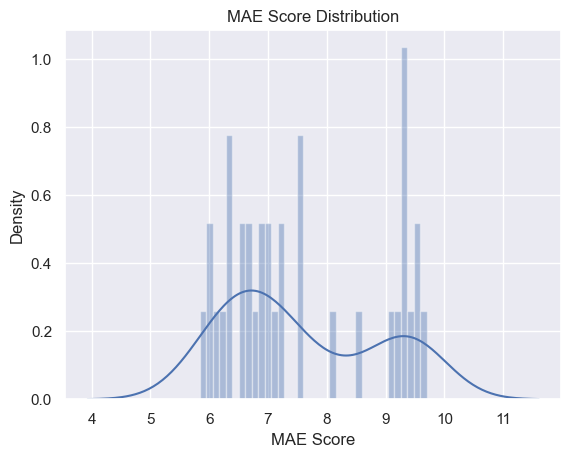

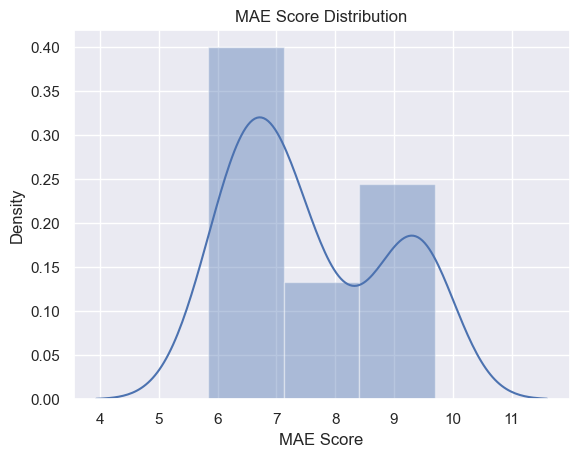

In [12]:
sns.set(style="darkgrid")
sns.distplot(mae_values, bins=35).set_title('MAE Score Distribution')
plt.xlabel("MAE Score")
plt.show()

sns.set(style="darkgrid")
sns.distplot(mae_values).set_title('MAE Score Distribution')
plt.xlabel("MAE Score")
plt.show()

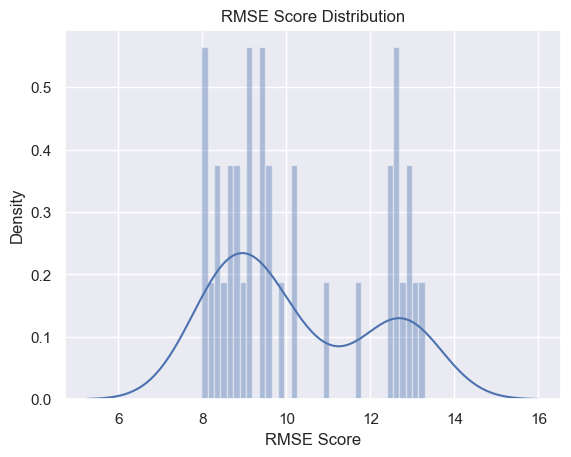

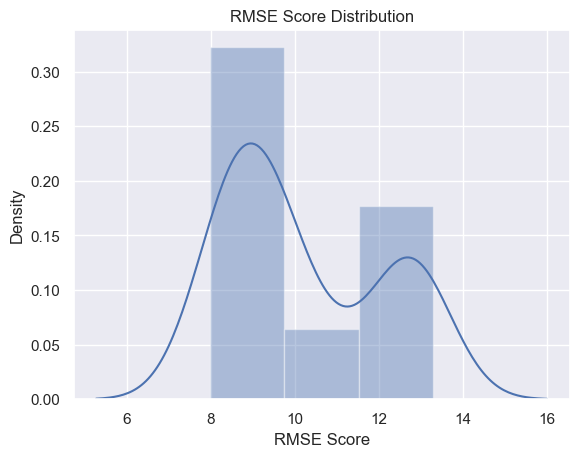

In [13]:
sns.set(style="darkgrid")
sns.distplot(rmse_values, bins=35).set_title('RMSE Score Distribution')
plt.xlabel("RMSE Score")
plt.show()

sns.set(style="darkgrid")
sns.distplot(rmse_values).set_title('RMSE Score Distribution')
plt.xlabel("RMSE Score")
plt.show()

# Results

In [14]:
compare_df.sort_values(by=['MAE'])

,Name,MAE,MAPE,MSE,RMSE
0,Vanilla LSTM 2,7.5747,0.018,107.3264,10.2006


https://machinelearningmastery.com/estimate-number-experiment-repeats-stochastic-machine-learning-algorithms/